In [91]:
%load_ext autoreload
%autoreload 2
import networkx as nx  
import matplotlib.pyplot as plt

import numpy as np
import sys
import pdb
from sklearn.model_selection import train_test_split
import random
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.autograd import Variable
from read_graph import read_graphs_in_networkx
from utils import calculate_M,graphs_db,encode_M_matrix,decode_M_matrix
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_file = "../data/breast.txt"
(graphs,node_dict,edge_dict) = read_graphs_in_networkx(data_file,False,10000)
print("Number of graphs loaded " , len(graphs))

(train_graphs,val_graphs) = train_test_split(graphs,test_size=0.1, random_state=42)
(train_graphs,test_graphs) = train_test_split(train_graphs,test_size=0.2, random_state=42)

Number of graphs loaded  10000


In [3]:
max_num_edges = max([graph.number_of_edges() for graph in graphs])
min_num_edges = min([graph.number_of_edges() for graph in graphs])
max_num_nodes = max([graph.number_of_nodes() for graph in graphs])
min_num_nodes = min([graph.number_of_nodes() for graph in graphs])
M = int(calculate_M(graphs,len(graphs)))
print("Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes", len(train_graphs), max_num_nodes, min_num_nodes, max_num_edges, min_num_edges,M)


Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes 7200 111 6 116 5 18


In [4]:

        
graph_db = graphs_db(graphs,max_num_nodes,M)
(a, b,c) = graph_db.__getitem__(10)
graph_loader = DataLoader(graph_db,batch_size= 32,num_workers=2,shuffle=True)



In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [ ]:
#for batch_ndx, sample in enumerate(graph_loader):
    #print(batch_ndx)
#     print(sample[2])

### Training code ###

In [6]:

class CUSTOM_RNN(torch.nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=32,output_size =None,number_layers=4,name=""):
        super(CUSTOM_RNN, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_layers = number_layers
        self.name = name
        
        
        self.linear = nn.Linear(self.input_size,self.embedding_size)
        self.rnn = nn.GRU(input_size=self.embedding_size,hidden_size = self.hidden_size,
                                num_layers=self.number_layers,bias=True,batch_first=True,dropout=0)
        self.hidden_n = None
        self.out = nn.Sequential(nn.Linear(self.hidden_size,self.embedding_size),nn.ReLU(),nn.Linear(self.embedding_size,self.output_size))
        
        self.relu = nn.ReLU()
        
    def forward(self,input,is_packed=False, seq_lengths = None):
        #print("doing forward loop for rnn ," ,self.name)
        input = self.relu(self.linear(input))
        if is_packed:
            input = pack_padded_sequence(input,seq_lengths,batch_first=True,enforce_sorted=False)
        output,self.hidden_n = self.rnn(input,self.hidden_n)
        if is_packed:
            output = pad_packed_sequence(output,batch_first=True)[0]
        output = self.out(output)
        return output
        
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.number_layers, batch_size, self.hidden_size))

        
### Define two RNNs 1 for graph level and 2nd for edge level 
hidden_size_node_rnn = 64
hidden_size_edge_rnn = 16
embedding_size_node_rnn = 32
embedding_size_edge_rnn = 8
num_layers = 4
node_rnn = CUSTOM_RNN(input_size=M, embedding_size=embedding_size_node_rnn,
                hidden_size=hidden_size_node_rnn, number_layers=num_layers,output_size=hidden_size_edge_rnn,name="node")
edge_rnn = CUSTOM_RNN(input_size=1, embedding_size=embedding_size_edge_rnn,
                   hidden_size=hidden_size_edge_rnn, number_layers=num_layers, output_size=1,name="edge")

lr = 0.0001
optimizer_node = optim.Adam(list(node_rnn.parameters()), lr=lr)
optimizer_edge = optim.Adam(list(edge_rnn.parameters()),lr=lr)



In [100]:

epochs = 10
for epoch in range(0,epochs):
    print("####Epoch#### ", epoch)
    node_rnn.train()
    edge_rnn.train()
    loss = 0
    for _, data in enumerate(graph_loader):
        node_rnn.zero_grad()
        edge_rnn.zero_grad()
        
        max_seq_len = max(data[2])
        node_rnn.hidden_n = node_rnn.init_hidden(batch_size=list(data[0].size())[0]) 
        x = data[0].float()[:,0:max_seq_len,:]
        y = data[0].float()[:,0:max_seq_len,:]
        h = node_rnn(x, is_packed=True, seq_lengths=data[2])
        h = pack_padded_sequence(h,data[2],batch_first=True,enforce_sorted=False).data
        
        
        ### initialized edge rnn with node rnn hiddent state
        h_edge_tmp = torch.zeros(num_layers-1, h.size(0), h.size(1))
        edge_rnn.hidden_n = torch.cat((h.view(1,h.size(0),h.size(1)),h_edge_tmp),dim=0)
        y_packed = pack_padded_sequence(y,data[2],batch_first=True,enforce_sorted=False).data
        edge_rnn_y = y_packed.view(y_packed.size(0),y_packed.size(1),1)
        edge_rnn_x = torch.cat((torch.ones(edge_rnn_y.size(0),1,1),edge_rnn_y[:,0:-1,0:1]),dim=1)
        edge_rnn_y_pred = edge_rnn(edge_rnn_x, is_packed=False)
        #print(edge_rnn_y_pred.shape)
        edge_rnn_y_pred = F.sigmoid(edge_rnn_y_pred)
        loss = F.binary_cross_entropy(edge_rnn_y_pred, edge_rnn_y)
        loss.backward()
        optimizer_edge.step()
        optimizer_node.step()
        print(loss)

        #print(h.size())
        
        

####Epoch####  0


/Users/shubham/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.0843, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0848, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0808, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0820, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0814, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0861, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0826, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0859, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0812, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0816, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0827, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0806, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0830, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0847, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0857, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0892, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0802, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0844, grad_fn=<BinaryCrossEntropyBack

tensor(0.0857, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0821, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0831, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0782, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0822, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0825, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0803, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0848, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0879, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0817, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0814, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0832, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0843, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0813, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0771, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0822, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0799, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBack

tensor(0.0778, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0793, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0820, grad_fn=<BinaryCrossEntropyBackward>)
####Epoch####  1
tensor(0.0815, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0839, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0818, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0783, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0818, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0799, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0805, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0801, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0829, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0815, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0811, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0807, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0771, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0788, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0837, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0805, grad_fn=<Binar

tensor(0.0634, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0662, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0665, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0654, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0632, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0663, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0658, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0654, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0644, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0632, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0626, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0658, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0612, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0616, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0616, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBack

tensor(0.0702, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0748, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0703, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0739, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0748, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0681, grad_fn=<BinaryCrossEntropyBackward>)
####Epoch####  2
tensor(0.0844, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0780, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0728, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0732, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0729, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0749, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0665, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0633, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0687, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0644, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0646, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0657, grad_fn=<Binar

tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBack

tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward>)
####Epoch####  3
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0533, grad_fn=<Binar

tensor(0.0496, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0507, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0512, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0504, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0496, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBack

tensor(0.0502, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0512, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0511, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0514, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0498, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0518, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward>)
####Epoch####  4
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0514, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0504, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0510, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0500, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0501, grad_fn=<Binar

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0517, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0511, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0511, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0506, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0511, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0514, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0518, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0496, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0495, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0502, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0509, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0488, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0517, grad_fn=<BinaryCrossEntropyBack

tensor(0.0499, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0502, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0505, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0503, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0476, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0457, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0488, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0495, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0508, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0499, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0476, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0515, grad_fn=<BinaryCrossEntropyBackward>)
####Epoch####  5
tensor(0.0491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0514, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0486, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0485, grad_fn=<Binar

tensor(0.0508, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0503, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0490, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0508, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0488, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0495, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0507, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0496, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0472, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0507, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0477, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0512, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0499, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0515, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0501, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0510, grad_fn=<BinaryCrossEntropyBack

tensor(0.0486, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0477, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0483, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0473, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0474, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0495, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0470, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0489, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0484, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0501, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0469, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0508, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0486, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0505, grad_fn=<BinaryCrossEntropyBackward>)
####Epoch####  6
tensor(0.0471, grad_fn=<Binar

tensor(0.0496, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0474, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0476, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0482, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0468, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0474, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0484, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0469, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0514, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0457, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0474, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0466, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0493, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0485, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0496, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0505, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0481, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0460, grad_fn=<BinaryCrossEntropyBack

tensor(0.0473, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0459, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0477, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0472, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0481, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0473, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0475, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0474, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0474, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0469, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0492, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0496, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0512, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0467, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0498, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0481, grad_fn=<BinaryCrossEntropyBack

tensor(0.0485, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0487, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0474, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0464, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0459, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0468, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0458, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0464, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0458, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0461, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0448, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0472, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0465, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0476, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0462, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0481, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0457, grad_fn=<BinaryCrossEntropyBack

tensor(0.0480, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0472, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0434, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0462, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0454, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0479, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0466, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0466, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0479, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0464, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0451, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0480, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0447, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0461, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0449, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0474, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0461, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0468, grad_fn=<BinaryCrossEntropyBack

tensor(0.0449, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0443, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0434, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0453, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0448, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0434, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0452, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0444, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0440, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0466, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0439, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0481, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0447, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0456, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0463, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0471, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0467, grad_fn=<BinaryCrossEntropyBack

tensor(0.0448, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0452, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0440, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0450, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0455, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0451, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0441, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0477, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0454, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0440, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0467, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0441, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0457, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0447, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0439, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0456, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0445, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0451, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0437, grad_fn=<BinaryCrossEntropyBack

tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0458, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0455, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0469, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0463, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0447, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0440, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0465, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0433, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0449, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0446, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0432, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0434, grad_fn=<BinaryCrossEntropyBack

tensor(0.0452, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0457, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0455, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0457, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0462, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0423, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0459, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0423, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0435, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0433, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0429, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0447, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0460, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0448, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0428, grad_fn=<BinaryCrossEntropyBack

tensor(0.0421, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0436, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0431, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0412, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0436, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0408, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0450, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0449, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0403, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0445, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0428, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0441, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0441, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0426, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0407, grad_fn=<BinaryCrossEntropyBack

tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0441, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0441, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0426, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0416, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0428, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0436, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0436, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0436, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0398, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0410, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0424, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0471, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0501, grad_fn=<BinaryCrossEntropyBack

tensor(0.0424, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0411, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0446, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0449, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0437, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0404, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0443, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0443, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0415, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0426, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0399, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0414, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0432, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0427, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0403, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBack

tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0438, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0439, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0440, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0420, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0437, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0457, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0414, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0394, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0423, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0392, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0398, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0414, grad_fn=<BinaryCrossEntropyBack

tensor(0.0403, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0400, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0427, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0425, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0427, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0435, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0396, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0435, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0423, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0402, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0407, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0429, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0445, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0429, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0435, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0433, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0415, grad_fn=<BinaryCrossEntropyBack

tensor(0.0399, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0454, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0406, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0416, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0427, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0416, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0420, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0412, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0399, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0421, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0466, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0413, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0408, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0444, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0376, grad_fn=<BinaryCrossEntropyBack

tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0399, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0425, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0394, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0427, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0451, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0403, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0398, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0433, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0424, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0410, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0408, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0390, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0394, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0425, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0393, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0414, grad_fn=<BinaryCrossEntropyBack

tensor(0.0397, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0398, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0400, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0407, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0411, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0408, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0391, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0398, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0431, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0391, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0393, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0414, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0453, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0391, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0394, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBack

tensor(0.0384, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0387, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0399, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0402, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0433, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0415, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0400, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0462, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0399, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0395, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0402, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0416, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0414, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0396, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0398, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0400, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0390, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0428, grad_fn=<BinaryCrossEntropyBack

tensor(0.0441, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0415, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0398, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0377, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0426, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0408, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0395, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0427, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0409, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0416, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0403, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0400, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0388, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0414, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0410, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0407, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0430, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0411, grad_fn=<BinaryCrossEntropyBack

tensor(0.0388, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0414, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0383, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0391, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0381, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0395, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0428, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0401, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0385, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0392, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0409, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0444, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0397, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0374, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0397, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0395, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0375, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0370, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0366, grad_fn=<BinaryCrossEntropyBack

tensor(0.0386, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0409, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0375, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0380, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0400, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0390, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0409, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0381, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0404, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0393, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0376, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0401, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0406, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0395, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0374, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0395, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0385, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0368, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0405, grad_fn=<BinaryCrossEntropyBack

tensor(0.0413, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0385, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0397, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0394, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0383, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0375, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0383, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0365, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0380, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0389, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0388, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0382, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0382, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0411, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0437, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0388, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0405, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0376, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0424, grad_fn=<BinaryCrossEntropyBack

tensor(0.0667, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0851, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0670, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0682, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0628, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0646, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0512, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0755, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0748, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0770, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0643, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0489, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0487, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0454, grad_fn=<BinaryCrossEntropyBack

tensor(0.0388, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0367, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0376, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0370, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0382, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0380, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0413, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0403, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0376, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0382, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0372, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0396, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0394, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0397, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0380, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0400, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0378, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0405, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0393, grad_fn=<BinaryCrossEntropyBack

tensor(0.0381, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0399, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0369, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0384, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0384, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0363, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0375, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0390, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0360, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0404, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0375, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0387, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0396, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0374, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0361, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0355, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0364, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0369, grad_fn=<BinaryCrossEntropyBack

tensor(0.0358, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0376, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0364, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0370, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0350, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0390, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0381, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0358, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0356, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0374, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0390, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0376, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0384, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0383, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0374, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0372, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0412, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0366, grad_fn=<BinaryCrossEntropyBack

tensor(0.0368, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0391, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0367, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0369, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0373, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0349, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0358, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0343, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0381, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0344, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0372, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0393, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0355, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0372, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0379, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0334, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0384, grad_fn=<BinaryCrossEntropyBack

tensor(0.0343, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0382, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0355, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0372, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0373, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0368, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0353, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0398, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0374, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0380, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0366, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0394, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0389, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0347, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0353, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0364, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0353, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0363, grad_fn=<BinaryCrossEntropyBack

tensor(0.0343, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0350, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0356, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0346, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0365, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0351, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0369, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0388, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0379, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0379, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0346, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0404, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0357, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0365, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0354, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0395, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0352, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0360, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0348, grad_fn=<BinaryCrossEntropyBack

tensor(0.0347, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0380, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0387, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0351, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0354, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0367, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0377, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0373, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0367, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0371, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0355, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0354, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0350, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0373, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0348, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0360, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0340, grad_fn=<BinaryCrossEntropyBack

tensor(0.0318, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0344, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0326, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0327, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0351, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0344, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0348, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0342, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0355, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0367, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0344, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0354, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0372, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0333, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0374, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0329, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0331, grad_fn=<BinaryCrossEntropyBack

tensor(0.0357, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0349, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0317, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0374, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0346, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0357, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0385, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0326, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0339, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0350, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0339, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0369, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0353, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0355, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0381, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0338, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0338, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0351, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0324, grad_fn=<BinaryCrossEntropyBack

tensor(0.0330, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0361, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0322, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0363, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0351, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0300, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0312, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0357, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0338, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0320, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0320, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0331, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0347, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0349, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0338, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0337, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0325, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0340, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0372, grad_fn=<BinaryCrossEntropyBack

tensor(0.0337, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0340, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0297, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0331, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0355, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0325, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0355, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0338, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0321, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0371, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0342, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0323, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0334, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0347, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0324, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0318, grad_fn=<BinaryCrossEntropyBack

tensor(0.0342, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0313, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0334, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0340, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0313, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0334, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0326, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0326, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0298, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0349, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0336, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0330, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0343, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0376, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0322, grad_fn=<BinaryCrossEntropyBack

tensor(0.0358, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0331, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0335, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0301, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0317, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0319, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0326, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0353, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0310, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0326, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0348, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0320, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0314, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0309, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0351, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0323, grad_fn=<BinaryCrossEntropyBack

tensor(0.0318, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0303, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0318, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0314, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0334, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0335, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0327, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0303, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0339, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0318, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0299, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0319, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0304, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0295, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0329, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0308, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0358, grad_fn=<BinaryCrossEntropyBack

tensor(0.0308, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0327, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0301, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0354, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0301, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0331, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0313, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0309, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0322, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0333, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0288, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0308, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0321, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0332, grad_fn=<BinaryCrossEntropyBack

tensor(0.0324, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0299, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0353, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0324, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0319, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0325, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0288, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0302, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0299, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0359, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0305, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0305, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0339, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0327, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0338, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0277, grad_fn=<BinaryCrossEntropyBack

tensor(0.0324, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0293, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0305, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0285, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0325, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0297, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0299, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0287, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0309, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0309, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0301, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0320, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0303, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0299, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0319, grad_fn=<BinaryCrossEntropyBack

tensor(0.0295, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0290, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0317, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0289, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0307, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0290, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0289, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0314, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0287, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0289, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0343, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0310, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0291, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0293, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0312, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0298, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0307, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0305, grad_fn=<BinaryCrossEntropyBack

tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0300, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0301, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0282, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0313, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0321, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0276, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0267, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0327, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0327, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0319, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0264, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0304, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0281, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0278, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0317, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0295, grad_fn=<BinaryCrossEntropyBack

tensor(0.0285, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0286, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0295, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0265, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0307, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0307, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0321, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0271, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0291, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0292, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0262, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0280, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0305, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0283, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0287, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0286, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0293, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0330, grad_fn=<BinaryCrossEntropyBack

tensor(0.0309, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0285, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0283, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0275, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0324, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0277, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0339, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0275, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0309, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0292, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0276, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0318, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0289, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0275, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0298, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0259, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0287, grad_fn=<BinaryCrossEntropyBack

tensor(0.0421, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0408, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0350, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0407, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0383, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0446, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0411, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0408, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0384, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0380, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0338, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0307, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0363, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0363, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0322, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0339, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0326, grad_fn=<BinaryCrossEntropyBack

tensor(0.0261, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0301, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0266, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0281, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0289, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0284, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0305, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0293, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0287, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0282, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0307, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0287, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0288, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0299, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0284, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0283, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0287, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0284, grad_fn=<BinaryCrossEntropyBack

tensor(0.0272, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0326, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0304, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0324, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0279, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0283, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0289, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0252, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0290, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0307, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0288, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0285, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0266, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0259, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0274, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0295, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0295, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0277, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0275, grad_fn=<BinaryCrossEntropyBack

tensor(0.0293, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0273, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0273, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0271, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0283, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0273, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0350, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0267, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0257, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0270, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0294, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0257, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0271, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0276, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0274, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0264, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0276, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0304, grad_fn=<BinaryCrossEntropyBack

tensor(0.0257, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0270, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0270, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0289, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0282, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0268, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0289, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0263, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0294, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0280, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0285, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0265, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0253, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0269, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0264, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0321, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0282, grad_fn=<BinaryCrossEntropyBack

### TESTING ####

In [77]:
num_graphs_to_be_generated = 1000
node_rnn.hidden_n = node_rnn.init_hidden(num_graphs_to_be_generated)
node_rnn.eval()
edge_rnn.eval()
generated_graphs =torch.zeros(num_graphs_to_be_generated, max_num_nodes, M)
node_x = torch.ones(num_graphs_to_be_generated,1,M)
for i in range(max_num_nodes):
    #print(i)
    h = node_rnn(node_x,is_packed=False)
    
    h_edge_tmp = torch.zeros(num_layers-1, h.size(0), h.size(2))
    edge_rnn.hidden_n = torch.cat((h.view(1,h.size(0),h.size(2)),h_edge_tmp),dim=0)
    edge_x = torch.ones(num_graphs_to_be_generated,1,1)
    node_x = torch.zeros(num_graphs_to_be_generated,1,M)
    for j in range(min(M,i+1)):
        #print(j)
        edge_rnn_y_pred = edge_rnn(edge_x,is_packed=False)
        edge_rnn_y_pred_sigmoid = F.sigmoid(edge_rnn_y_pred)
        sampalar = torch.rand(edge_rnn_y_pred_sigmoid.size(0),1,1)
        edge_rnn_y_pred_sampled = torch.gt(edge_rnn_y_pred_sigmoid,sampalar).float() 
        node_x[:,:,j:j+1] = edge_rnn_y_pred_sampled
        edge_x = edge_rnn_y_pred_sampled
        
    
    generated_graphs[:, i:i + 1, :] = node_x
        


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


In [86]:
# remove all zeros rows and columns
adj = adj[~np.all(adj == 0, axis=1)]
adj = adj[:, ~np.all(adj == 0, axis=0)]
adj = np.asmatrix(adj)
G = nx.from_numpy_matrix(adj)
return G
predicted_graphs = []
predicted_graphs_x = []
for i in range(num_graphs_to_be_generated):
    predicted_graphs.append(decode_M_matrix(generated_graphs[i].numpy(),M))
    predicted_graphs_x.append(nx.from_numpy_matrix(predicted_graphs[i]))

In [87]:
max_num_edges = max([graph.number_of_edges() for graph in predicted_graphs_x])
min_num_edges = min([graph.number_of_edges() for graph in predicted_graphs_x])
max_num_nodes = max([graph.number_of_nodes() for graph in predicted_graphs_x])
min_num_nodes = min([graph.number_of_nodes() for graph in predicted_graphs_x])
print("Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes", max_num_nodes, min_num_nodes, max_num_edges, min_num_edges,M)

Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes 112 112 127 96 18


In [ ]:
        # save model checkpoint
        if args.save:
            if epoch % args.epochs_save == 0:
                fname = args.model_save_path + args.fname + 'lstm_' + str(epoch) + '.dat'
                torch.save(rnn.state_dict(), fname)
                fname = args.model_save_path + args.fname + 'output_' + str(epoch) + '.dat'
                torch.save(output.state_dict(), fname)
                
                
                 # check if load existing model
    if args.load:
        fname = args.model_save_path + args.fname + 'lstm_' + str(args.load_epoch) + '.dat'
        rnn.load_state_dict(torch.load(fname))
        fname = args.model_save_path + args.fname + 'output_' + str(args.load_epoch) + '.dat'
        output.load_state_dict(torch.load(fname))

        args.lr = 0.00001
        epoch = args.load_epoch
        print('model loaded!, lr: {}'.format(args.lr))

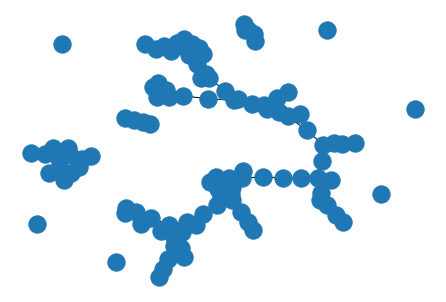

In [99]:
nx.draw(predicted_graphs_x[890], cmap = plt.get_cmap('jet'))
plt.show()